<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [70]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [71]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

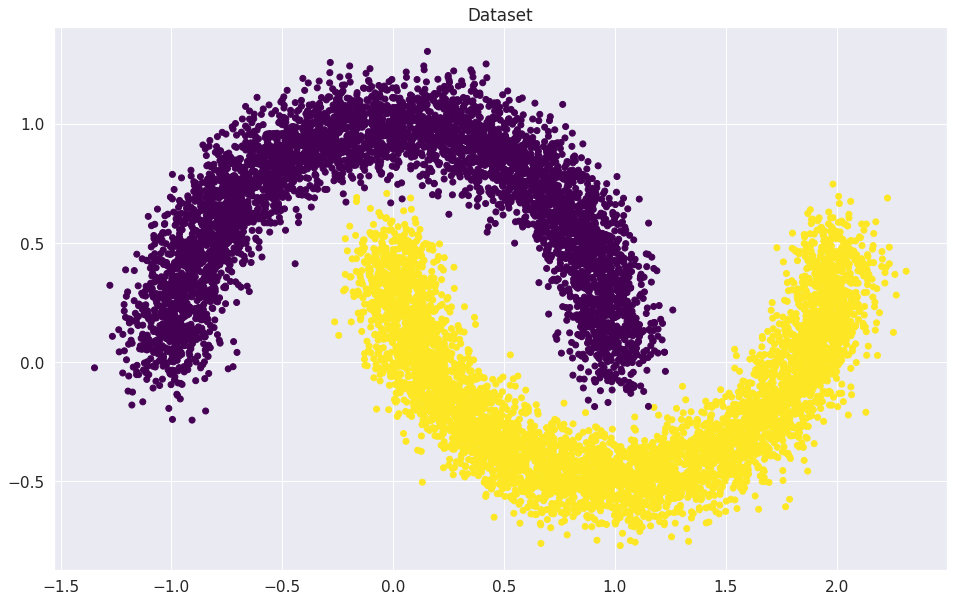

In [72]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [74]:
X_train_t =  torch.FloatTensor(X_train)# YOUR CODE GOES HERE
y_train_t = torch.LongTensor(y_train) # YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.LongTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [75]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [76]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))# YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights# YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term# YOUR CODE GOES HERE
        return x

In [77]:
linear_regression = LinearRegression(2, 1,bias=True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [78]:
s=0
for param in linear_regression.parameters():
   s+=len(param)
print(f'Модель имеет {s} обучаемых параметра')

Модель имеет 3 обучаемых параметра


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [79]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)# YOUR CODE. Use linear_regression to get outputs
        y_batch=y_batch.type_as(outp)
        loss =  loss_function(outp,y_batch.view(-1,1))# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = outp.sigmoid() # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.15625
Iteration: 100
Batch accuracy: 0.453125
Iteration: 200
Batch accuracy: 0.7265625
Iteration: 300
Batch accuracy: 0.84375
Iteration: 400
Batch accuracy: 0.8203125
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8046875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8203125

Iteration: 936.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [80]:
print(f'Алгоритм сошелся через {it + epoch * len(train_dataloader)} итераций \nВсе закончилось на {epoch} эпохе' )

Алгоритм сошелся через 936 итераций 
Все закончилось на 15 эпохе


### Визуализируем результаты

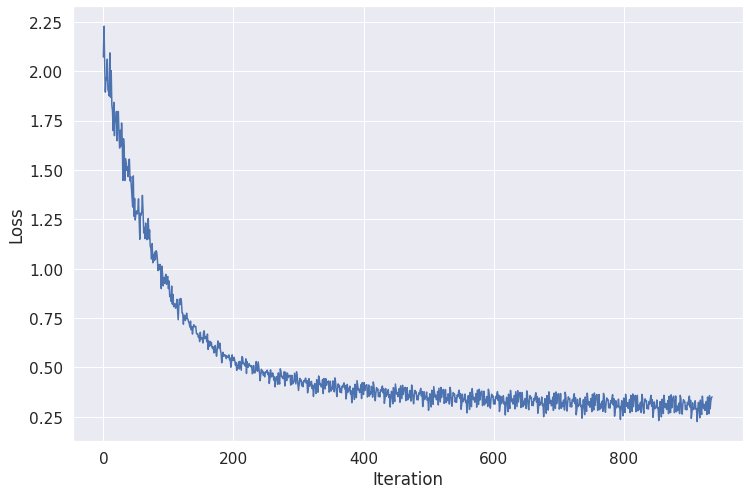

In [81]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

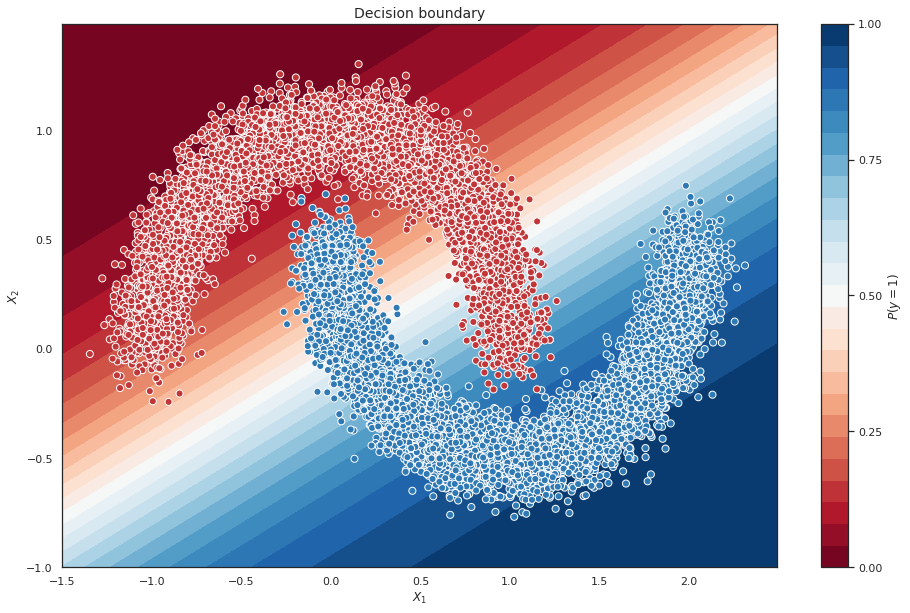

In [82]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [83]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch).sigmoid()#YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [84]:
from sklearn.metrics import accuracy_score #TP+TN / TP+TN+FN+FP

y_predict=predict(val_dataloader,linear_regression)
y_predict=np.round(y_predict)
print(f'accuracy после обучения получается {accuracy_score(y_predict,y_val_t)}')

# YOUR CODE. Compute total accuracy

accuracy после обучения получается 0.8596


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [85]:
accuracy_score(y_predict,y_val_t)

0.8596

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [86]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset,batch_size=1000)# YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset,batch_size=1000)   # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [87]:
train_dataloader.dataset.train_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [88]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [89]:

activation=nn.ELU
model = nn.Sequential(
    nn.Flatten(),  #разворачиваем матрицу в массив 28*28
    nn.Linear(28*28,128),
    activation(),
    nn.Linear(128,10),
    activation(),
    #YOUR CODE. Add layers to your sequential class
 )

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [93]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp=model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval()
              outp=model(x_batch)
                   
            preds = outp.argmax(-1)  #
            correct=sum(preds==y_batch) # кол-во данных, для которых верно предсказан класс YOUR CODE GOES HERE
            all = x_batch.size()[0]   #-кол-во строк, те кол-во данных # 
            epoch_correct += correct.item()
            epoch_all += all            
            if k == "train":  # делаем шаг оптимизации
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train": 
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7886166666666666
Loader: valid. Accuracy: 0.8933
Epoch: 2
Loader: train. Accuracy: 0.8962833333333333
Loader: valid. Accuracy: 0.911
Epoch: 3
Loader: train. Accuracy: 0.9092833333333333
Loader: valid. Accuracy: 0.9186
Epoch: 4
Loader: train. Accuracy: 0.9168166666666666
Loader: valid. Accuracy: 0.9244
Epoch: 5
Loader: train. Accuracy: 0.9243666666666667
Loader: valid. Accuracy: 0.9299
Epoch: 6
Loader: train. Accuracy: 0.9318833333333333
Loader: valid. Accuracy: 0.9335
Epoch: 7
Loader: train. Accuracy: 0.9385333333333333
Loader: valid. Accuracy: 0.9377
Epoch: 8
Loader: train. Accuracy: 0.9448833333333333
Loader: valid. Accuracy: 0.9433
Epoch: 9
Loader: train. Accuracy: 0.9498333333333333
Loader: valid. Accuracy: 0.9487
Epoch: 10
Loader: train. Accuracy: 0.9537666666666667
Loader: valid. Accuracy: 0.9519


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [94]:
elu_accuracy = accuracy["valid"]

In [95]:
from tqdm import tqdm

In [132]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  model1 = nn.Sequential(
    nn.Flatten(),  #разворачиваем матрицу в массив 28*28
    nn.Linear(28*28,128),
    activation(),
    nn.Linear(128,10),
    activation(),
    #YOUR CODE. Add layers to your sequential class
 )
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model1.parameters())
  
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model1.train()
              optimizer.zero_grad()
              outp=model1(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model1.eval()
              outp=model1(x_batch)
                   
            preds = outp.argmax(-1)  #
            correct=sum(preds==y_batch) # кол-во данных, для которых верно предсказан класс YOUR CODE GOES HERE
            all = x_batch.size()[0]   #-кол-во строк, те кол-во данных # 
            epoch_correct += correct.item()
            epoch_all += all            
            if k == "train":  # делаем шаг оптимизации
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
       # if k == "train": 
       #     print(f"Epoch: {epoch+1}")
       # print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
   
  return accuracy['valid']

In [133]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)#YOUR CODE
leaky_relu_accuracy =test_activation_function(nn.LeakyReLU) #YOUR CODE

100%|██████████| 10/10 [02:45<00:00, 16.54s/it]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

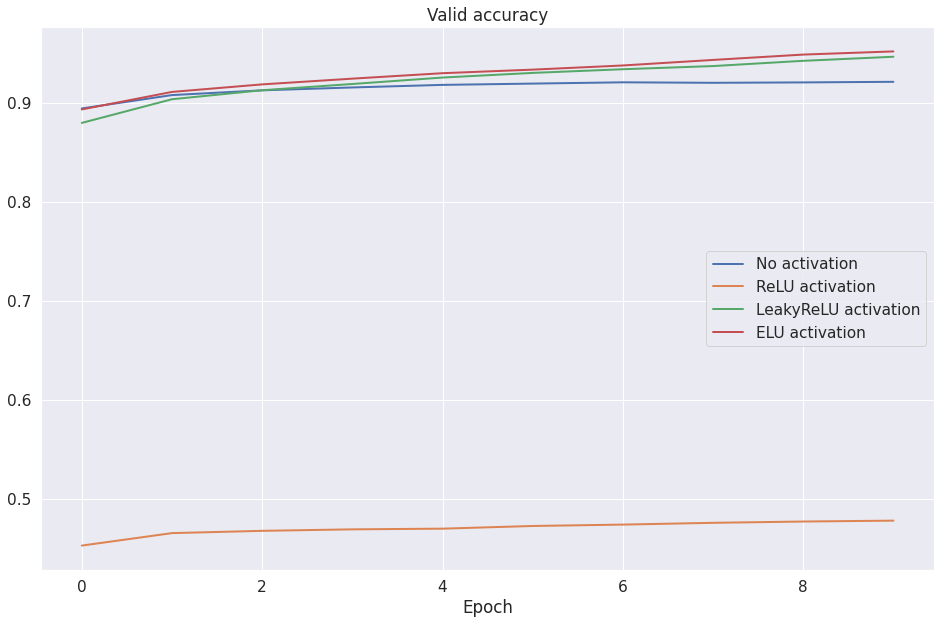

In [134]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

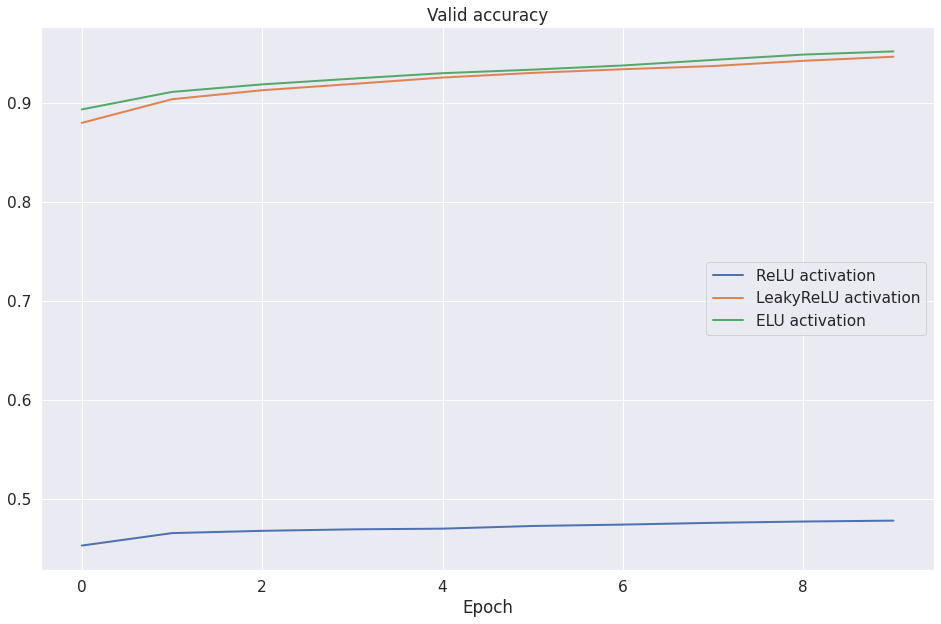

In [135]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

ELU!

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [136]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-10 13:17:04--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-10 13:17:05--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   219KB/s    in 0.2s    

2021-11-10 13:17:06 (219 KB/s) - ‘sample_photo.jpg’ saved [49337/4

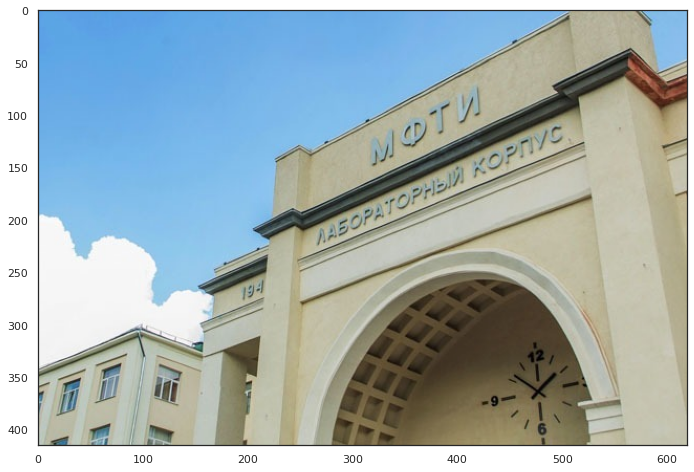

In [137]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [193]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
print(img_t.shape)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1,1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3,3, 1,1)

print(kernel.shape)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
result = F.conv2d(img_t, kernel)[0]  #

torch.Size([1, 415, 620, 3])
torch.Size([3, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


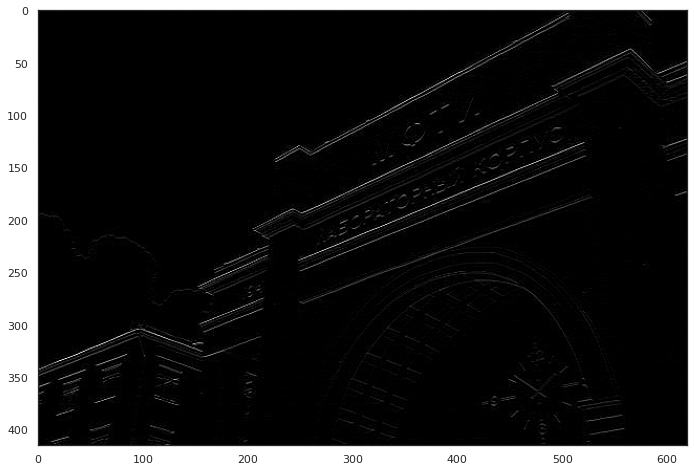

In [188]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 
A-2,  Б-5,  В-4, Г-6, Д-3, Е-1  

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [236]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3) 
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6,16,3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(2)#YOUR CODE
        self.fc1 = nn.Linear(400,120)  
        self.fc2 = nn.Linear(120,84)#YOUR CODE
        self.fc3 = nn.Linear(84,10)#YOUR CODE
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        fl=nn.Flatten()
        x=fl(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x= self.fc3(x)
        
        return x

In [237]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [246]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch=x_batch.to(device)
            y_batch=y_batch.to(device)

            outp=model.forward(x_batch)
            optimizer.zero_grad()

            preds = outp.argmax(-1)  #
            correct=sum(preds==y_batch) # кол-во данных, для которых верно предсказан класс YOUR CODE GOES HERE
            all = x_batch.size()[0]   #-кол-во строк, те кол-во данных в одном батче 
            epoch_correct += correct.item()
            epoch_all += all            
            if k == "train":  # делаем шаг оптимизации
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train": 
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.98155


 10%|█         | 1/10 [00:17<02:34, 17.11s/it]

Loader: valid. Accuracy: 0.9821
Epoch: 2
Loader: train. Accuracy: 0.9832833333333333


 20%|██        | 2/10 [00:34<02:17, 17.13s/it]

Loader: valid. Accuracy: 0.9829
Epoch: 3
Loader: train. Accuracy: 0.9845166666666667


 30%|███       | 3/10 [00:51<02:00, 17.17s/it]

Loader: valid. Accuracy: 0.984
Epoch: 4
Loader: train. Accuracy: 0.9859


 40%|████      | 4/10 [01:08<01:43, 17.18s/it]

Loader: valid. Accuracy: 0.9847
Epoch: 5
Loader: train. Accuracy: 0.9871833333333333


 50%|█████     | 5/10 [01:26<01:26, 17.24s/it]

Loader: valid. Accuracy: 0.985
Epoch: 6
Loader: train. Accuracy: 0.98835


 60%|██████    | 6/10 [01:43<01:08, 17.24s/it]

Loader: valid. Accuracy: 0.985
Epoch: 7
Loader: train. Accuracy: 0.98935


 70%|███████   | 7/10 [02:00<00:51, 17.25s/it]

Loader: valid. Accuracy: 0.9852
Epoch: 8
Loader: train. Accuracy: 0.9901666666666666


 80%|████████  | 8/10 [02:17<00:34, 17.24s/it]

Loader: valid. Accuracy: 0.9851
Epoch: 9
Loader: train. Accuracy: 0.9907166666666667


 90%|█████████ | 9/10 [02:35<00:17, 17.29s/it]

Loader: valid. Accuracy: 0.986
Epoch: 10
Loader: train. Accuracy: 0.9912166666666666


100%|██████████| 10/10 [02:52<00:00, 17.22s/it]

Loader: valid. Accuracy: 0.9856


In [247]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

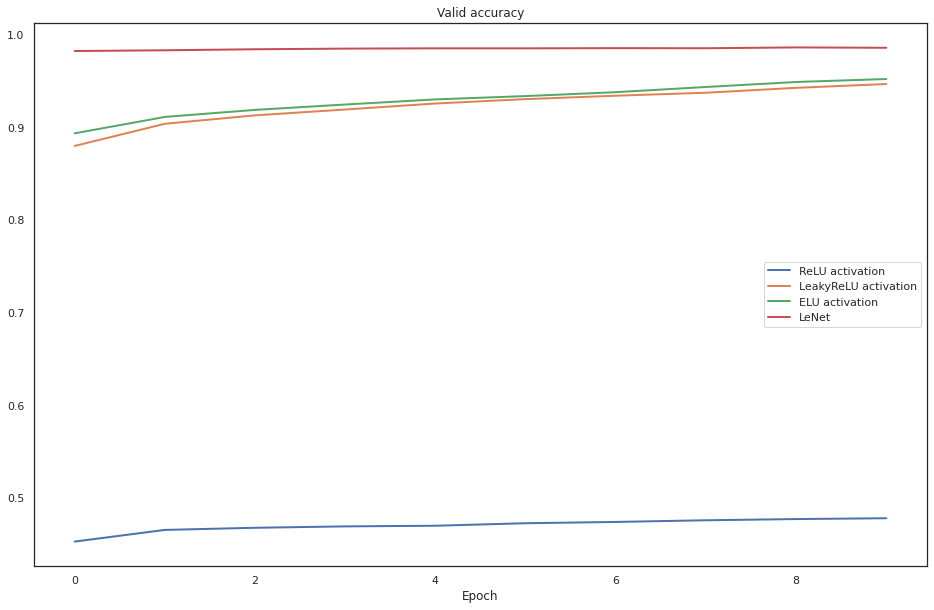

In [248]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [249]:
print(np.round(np.max(lenet_accuracy),2))

0.99
